In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import numpy as np
import random
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, RandomRotation, RandomCrop, GaussianBlur, ToPILImage

# Configuration

In [2]:
config = {
  "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
  "batch_size": 8,
  "learning_rate": 1e-3,
  "eta_min": 1e-7,
  "epoch_num": 600,
  "augmentation": True
}

# Dataloader & Dataset

In [3]:
import re

def sorted_alphanumeric(data):

    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, low_path, high_path, size = 256, augment=False):
        self.size = size
        self.low_path = low_path
        self.high_path = high_path
        self.augment = augment
        self.high_files = sorted_alphanumeric(os.listdir(high_path))
        self.low_files = sorted_alphanumeric(os.listdir(low_path))

        # Data augmentation
        self.random_horizontal_flip = RandomHorizontalFlip(p=1)
        self.random_vertical_flip = RandomVerticalFlip(p=1)
        self.random_rotation = RandomRotation(10)  # Rotate by 10 degrees
        self.color_jitter = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)

    def __len__(self):
        return len(self.low_files)
    
    def apply_same_transform(self, high_img, low_img):
        # Convert to PIL images for augmentation
        high_img = ToPILImage()(high_img)
        low_img = ToPILImage()(low_img)

        # Random Horizontal Flip
        if random.random() > 0.5:
            high_img = self.random_horizontal_flip(high_img)
            low_img = self.random_horizontal_flip(low_img)

        # Random Vertical Flip
        if random.random() > 0.5:
            high_img = self.random_vertical_flip(high_img)
            low_img = self.random_vertical_flip(low_img)

        return high_img, low_img

    def __getitem__(self, idx):

        high_img_path = os.path.join(self.high_path, self.high_files[idx])
        low_img_path = os.path.join(self.low_path, self.low_files[idx])

        high_img = cv2.imread(high_img_path, 1)
        high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)
        high_img = cv2.resize(high_img, (self.size, self.size))
        high_img = high_img.astype('float32') / 255.0

        low_img = cv2.imread(low_img_path, 1)
        low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
        low_img = cv2.resize(low_img, (self.size//4, self.size//4))
        low_img = low_img.astype('float32') / 255.0

        if self.augment:
            high_img, low_img = self.apply_same_transform(high_img, low_img)

        return {
            'high_img': ToTensor()(high_img),
            'low_img': ToTensor()(low_img)
        }

In [5]:
high_res_path = 'C:/Users/User/Downloads/Data/Train set/high_res'
low_res_path = 'C:/Users/User/Downloads/Data/Train set/low_res'
test_high_res_path = 'C:/Users/User/Downloads/Data/Test set/high_res'
test_low_res_path = 'C:/Users/User/Downloads/Data/Test set/low_res'

# Create dataset instance
dataset = ImageDataset(low_res_path, high_res_path, augment=config['augmentation'])
test_set = ImageDataset(test_low_res_path, test_high_res_path, augment=False)

# Check Dataset

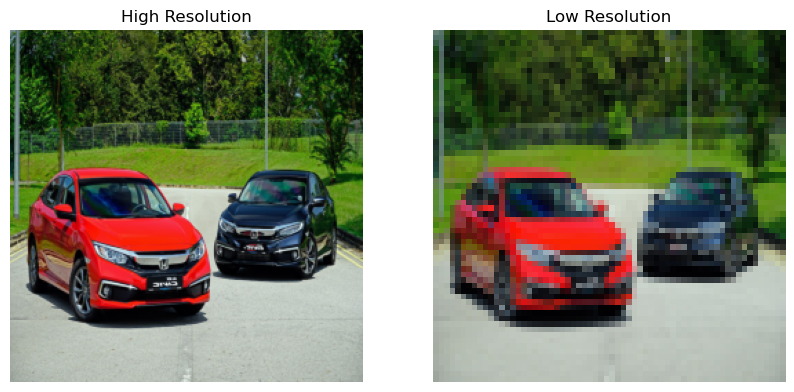

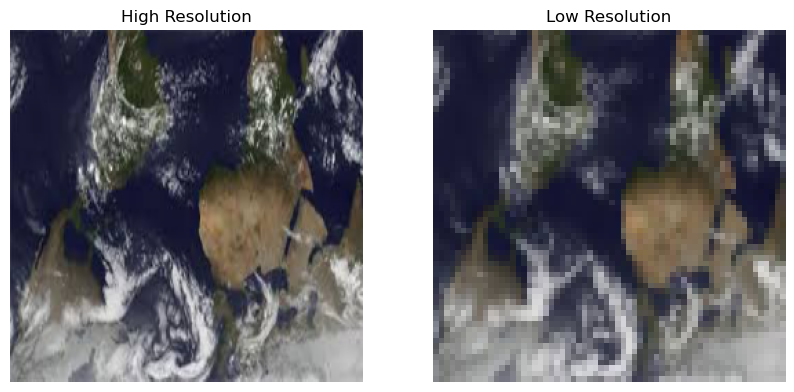

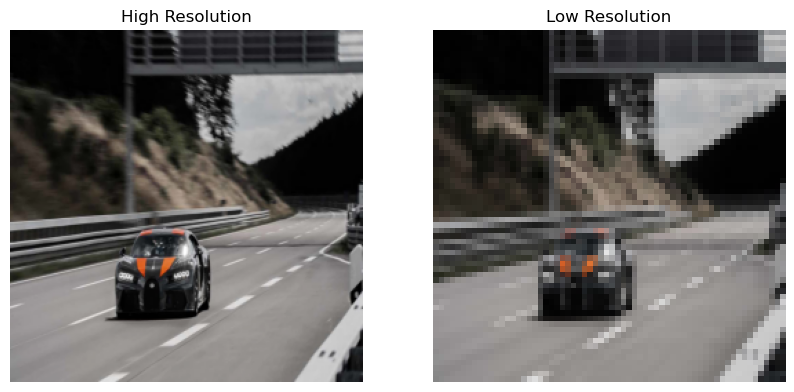

In [6]:
import matplotlib.pyplot as plt
import cv2
num_pairs_to_print = 3

for idx in range(num_pairs_to_print):
    sample = dataset[idx]
    high_img, low_img = sample['high_img'], sample['low_img']
    #Convert the pytorch tensors to numpy arrays
    #Matplotlib expects the images to be in the format : height, width, channels whereas the the pytroch tensor has it in the form of channels, height, width
    #After doing this we convert to the numpy array
    high_img_np = high_img.permute(1, 2, 0).numpy() if high_img.shape[0] == 3 else high_img.numpy()
    low_img_np = low_img.permute(1, 2, 0).numpy() if low_img.shape[0] == 3 else low_img.numpy()

    # Plot high-resolution and low-resolution images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(high_img_np)
    plt.title('High Resolution')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(low_img_np)
    plt.title('Low Resolution')
    plt.axis('off')

    plt.show()


In [7]:
from torch.utils.data import random_split

print("Number of high-resolution images:", len(dataset.high_files))
print("Number of low-resolution images:", len(dataset.low_files))
print("Number of Test high-resolution images:", len(test_set.high_files))
print("Number of Test low-resolution images:", len(test_set.low_files))

train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
# Split the dataset into train, validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])
print("Length of training set is: ", len(train_set))
print("Length of validation set is: ", len(val_set))
print("Length of testing set is: ", len(test_set))


Number of high-resolution images: 360
Number of low-resolution images: 360
Number of Test high-resolution images: 40
Number of Test low-resolution images: 40
Length of training set is:  288
Length of validation set is:  72
Length of testing set is:  40


In [8]:
batch_size = config['batch_size']
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# Model : PAN

In [9]:
class pixel_attention(nn.Module):
    def __init__(self, channels):
        super(pixel_attention, self).__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute attention weights
        attention_weights = self.sigmoid(self.conv(x))
        # Apply element-wise multiplication
        return x * attention_weights

In [10]:
class SCPA_block(nn.Module):
    def __init__(self, emb_dim):
        super(SCPA_block, self).__init__()
        self.emb_dim = emb_dim

        self.conv_half1_1 =     nn.Conv2d(in_channels=emb_dim//2, out_channels=emb_dim//2, kernel_size=1, stride=1)
        self.conv_half3_1 =     nn.Conv2d(in_channels=emb_dim//2, out_channels=emb_dim//2, kernel_size=3, stride=1, padding=1)
        self.pixel_attention =  pixel_attention(emb_dim//2)
        self.conv_half3_2 =     nn.Conv2d(in_channels=emb_dim//2, out_channels=emb_dim//2, kernel_size=3, stride=1, padding=1)

        self.conv_half1_2 = nn.Conv2d(in_channels=emb_dim//2, out_channels=emb_dim//2, kernel_size=1, stride=1)
        self.conv_half3_3 = nn.Conv2d(in_channels=emb_dim//2, out_channels=emb_dim//2, kernel_size=3, stride=1, padding=1)

        self.conv_full1 = nn.Conv2d(in_channels=emb_dim, out_channels=emb_dim, kernel_size=1, stride=1)

        self.act1 = nn.ReLU()

    def forward(self, x):
        channels = x.shape[1]
        half_channels = channels//2
        path1 = x[:, :half_channels, :, :]
        path2 = x[:, half_channels:, :, :] 

        # Path 1: with PA
        x1 = self.act1(self.conv_half1_1(path1))
        x1 = self.pixel_attention(x1) * self.act1(self.conv_half3_1(x1))
        x1 = self.act1(self.conv_half3_2(x1))

        # Path 2: No PA
        x2 = self.act1(self.conv_half1_2(path2))
        x2 = self.act1(self.conv_half3_2(x2))

        y = torch.cat((x1, x2), dim=1)
        y = self.act1(self.conv_full1(y)) + x

        return y

In [11]:
class UPA_block(nn.Module):
    def __init__(self, emb_dim, scale_factor=2):
        super(UPA_block, self).__init__()
        self.emb_dim = emb_dim
        self.scale_factor = scale_factor

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.conv1 = nn.Conv2d(emb_dim, emb_dim, kernel_size=3, stride=1, padding=1)
        self.pixel_attention = pixel_attention(emb_dim)
        self.conv2 = nn.Conv2d(emb_dim, emb_dim, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.conv1(x))
        x = self.pixel_attention(x)
        x = self.relu(self.conv2(x))
        
        return x

In [12]:
class PAN(nn.Module):
    def __init__(self, emb_dim=256, block_num=8):
        super(PAN, self).__init__()
        self.emb_dim = emb_dim
        self.block_num = block_num

        self.shallow_feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=emb_dim, kernel_size=3, stride=1, padding=1)
        )

        self.deep_feature = nn.Sequential(
            SCPA_block(emb_dim=emb_dim)
        )

        self.reconstruction = nn.Sequential(
            UPA_block(emb_dim=emb_dim)
        )

        self.conv1 = nn.Conv2d(in_channels=emb_dim, out_channels=3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.shallow_feature(x)

        for i in range(self.block_num):
            x = self.deep_feature(x)
        
        for i in range(2):
            x = self.reconstruction(x)

        x = self.conv1(x)

        return x

# Test Model Size

In [13]:
# model = TransformerSuperResolution()
model = PAN()

model = model.to(config['device'])
from torchsummary import summary
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 64, 64]           7,168
            Conv2d-2          [-1, 128, 64, 64]          16,512
              ReLU-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          16,512
           Sigmoid-5          [-1, 128, 64, 64]               0
   pixel_attention-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]         147,584
              ReLU-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]         147,584
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]          16,512
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
             ReLU-14          [-1, 128,

# Training

In [14]:
# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

In [15]:
import torch.optim as optim

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config['epoch_num']*len(train_set)//config['batch_size'], eta_min=config['eta_min'])

In [16]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)
# num_epochs : You can try 10~15 at first.
num_epochs = config['epoch_num']
psnr_best = 0.0
best_val_loss = np.Inf
history = []
filename = f'model2.pth'


# load saved best model to start training
if os.path.isfile(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    psnr_best = checkpoint['best_psnr']
    print(f"Loading best model with PSNR = {psnr_best:.4f}")
else:
    print('No saved model found. Start training ...')


for epoch in range(num_epochs):
    train_loss  = 0.0
    lrs         = []
    result      = {'train_loss': [], 'valid_loss': [], 'lrs': [], 'train_psnr': [], 'valid_psnr': []}
    
    # Training phase
    running_loss = 0.0
    train_psnr_total = 0
    running_len = 0
    # with tqdm(total=len(train_set)//config['batch_size'], desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False) as pbar:
    for batch_idx, data in enumerate(train_loader):
        low_img, high_img = data['low_img'].to(config['device']), data['high_img'].to(config['device'])

        # Please finish the "Training phase" code here.
        optimizer.zero_grad()
        output_img = model(low_img)
        # print(output_img.shape, high_img.shape)
        running_loss = criterion(output_img, high_img)
        running_loss.backward()
        optimizer.step()

        lrs.append(optimizer.param_groups[0]['lr'])
        train_loss += running_loss.item()*high_img.size(0)
        train_psnr_total += calculate_psnr(output_img, high_img)
        running_len += 1

        # pbar.set_postfix({"Train Loss": train_loss / running_len, "PSNR": train_psnr_total / running_len, "Learning rate":optimizer.param_groups[0]['lr']})
        # pbar.update(1)

        scheduler.step()


    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    psnr_total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            lr_imgs, hr_imgs = data['low_img'].to(config['device']), data['high_img'].to(config['device'])

            # Forward pass for validation
            # Please finish the "Validation phase" code here.
            output_img = model(lr_imgs)
            running_loss = criterion(output_img, hr_imgs)
            val_loss += running_loss.item() * hr_imgs.size(0)

            # Calculate PSNR for validation images
            psnr_total += calculate_psnr(output_img, hr_imgs)

    epoch_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_train_psnr = train_psnr_total / len(train_loader)
    avg_psnr = psnr_total / len(val_loader)

    # scheduler.step(avg_val_loss)

    result['train_loss'] = epoch_loss
    result['valid_loss'] = avg_val_loss
    result['lrs'] = lrs
    result['train_psnr'] = avg_train_psnr
    result['valid_psnr'] = avg_psnr
    history.append(result)

    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
    print(f'Epoch {epoch + 1}/{num_epochs}  Train Loss: {epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | PSNR: {avg_psnr:.2f} dB | LR: {current_lr:.2e}')

    if avg_psnr >= psnr_best:
        psnr_best = avg_psnr

        state = {
            'model_state_dict': model.state_dict(),
            'best_psnr': psnr_best
        }
        print(f"Save new best model with PSNR = {psnr_best:.4f}")
        torch.save(state, filename)

No saved model found. Start training ...
Epoch 1/600  Train Loss: 2.7571 | Val Loss: 0.9336 | PSNR: 15.41 dB | LR: 1.00e-03
Save new best model with PSNR = 15.4079
Epoch 2/600  Train Loss: 0.7167 | Val Loss: 0.5595 | PSNR: 19.39 dB | LR: 1.00e-03
Save new best model with PSNR = 19.3923
Epoch 3/600  Train Loss: 0.7563 | Val Loss: 0.5944 | PSNR: 19.59 dB | LR: 1.00e-03
Save new best model with PSNR = 19.5880
Epoch 4/600  Train Loss: 0.6092 | Val Loss: 0.4606 | PSNR: 21.20 dB | LR: 1.00e-03
Save new best model with PSNR = 21.1998
Epoch 5/600  Train Loss: 0.4805 | Val Loss: 0.3862 | PSNR: 22.80 dB | LR: 1.00e-03
Save new best model with PSNR = 22.7979
Epoch 6/600  Train Loss: 0.4101 | Val Loss: 0.4067 | PSNR: 22.82 dB | LR: 1.00e-03
Save new best model with PSNR = 22.8203
Epoch 7/600  Train Loss: 0.4409 | Val Loss: 0.5061 | PSNR: 21.45 dB | LR: 1.00e-03
Epoch 8/600  Train Loss: 0.4358 | Val Loss: 0.3248 | PSNR: 23.96 dB | LR: 1.00e-03
Save new best model with PSNR = 23.9623
Epoch 9/600  Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR for the testing data: 25.78 dB


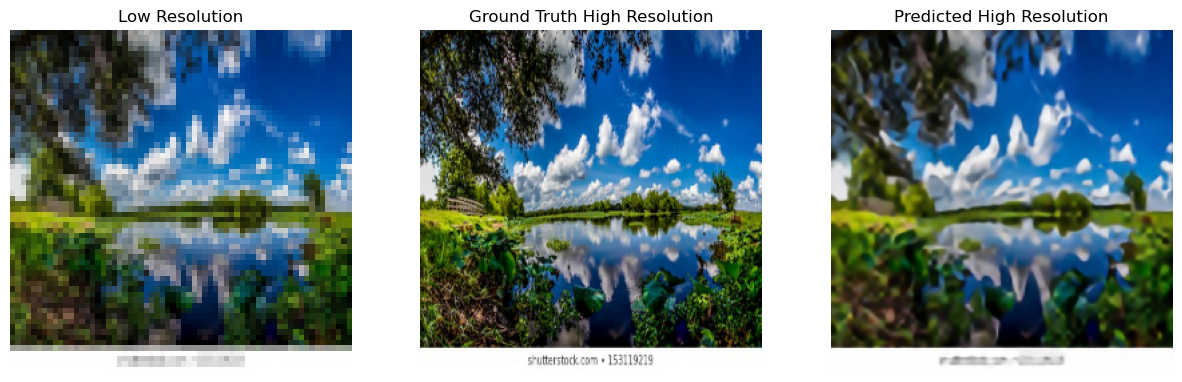

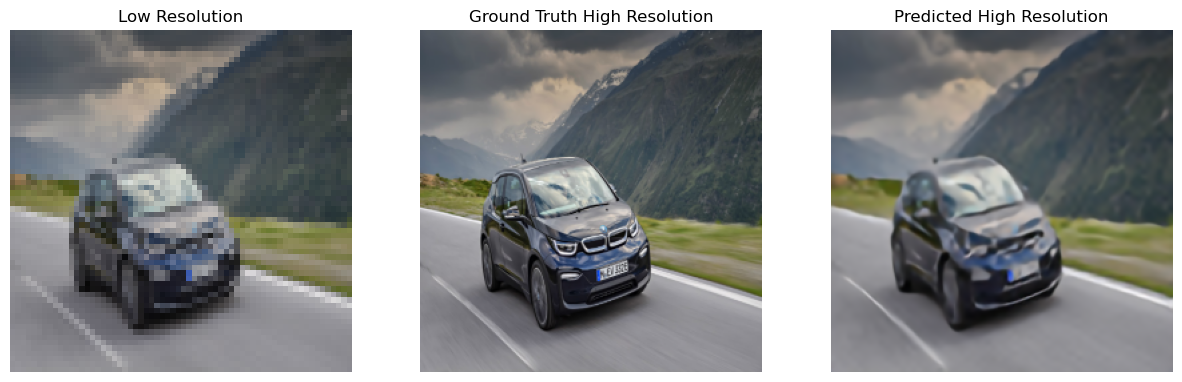

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


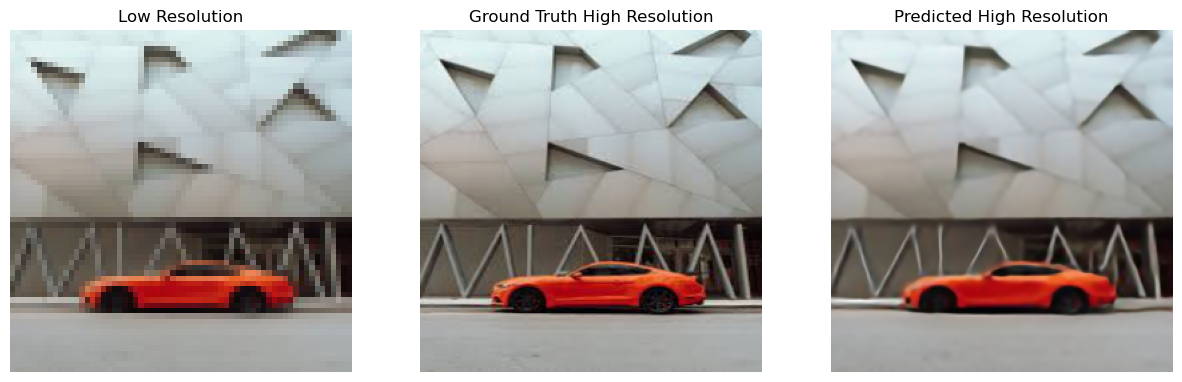

In [17]:
# load the model so that you don't need to train the model again
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint['model_state_dict'])
# model = torch.load("model.pth").to(device)

# Set the model to evaluation mode
model.eval()
total_test_psnr = 0.0

# Run the model to get the reconstructed high-resolution images
with torch.no_grad():
  for test_batch in test_loader:
    # Move the low-res and high-res images to the same device as the model
    low_img = test_batch['low_img'].to(config['device'])
    high_img = test_batch['high_img'].to(config['device'])    
    predicted_img = model(low_img)
    # Calculate PSNR for the current batch and accumulate the results
    psnr_value = calculate_psnr(predicted_img, high_img)
    total_test_psnr += psnr_value

test_psnr = total_test_psnr / len(test_loader)
print(f"PSNR for the testing data: {test_psnr:.2f} dB")

# Convert the tensors back to numpy arrays for visualization
high_img_np = high_img.cpu().permute(0, 2, 3, 1).numpy()  # (batch_size, height, width, channels)
low_img_np = low_img.cpu().permute(0, 2, 3, 1).numpy()    # (batch_size, height, width, channels)
predicted_img_np = predicted_img.cpu().permute(0, 2, 3, 1).numpy()  # (batch_size, height, width, channels)

# Plot some sample results
num_samples = 3  # Adjust this to show more/less samples
for i in range(num_samples):
    plt.figure(figsize=(15, 5))

    # Low resolution image
    plt.subplot(1, 3, 1)
    plt.imshow(low_img_np[i])
    plt.title('Low Resolution')
    plt.axis('off')

    # Ground truth high resolution image
    plt.subplot(1, 3, 2)
    plt.imshow(high_img_np[i])
    plt.title('Ground Truth High Resolution')
    plt.axis('off')

    # Predicted high resolution image
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_img_np[i])
    plt.title('Predicted High Resolution')
    plt.axis('off')

    plt.show()

# Plotting

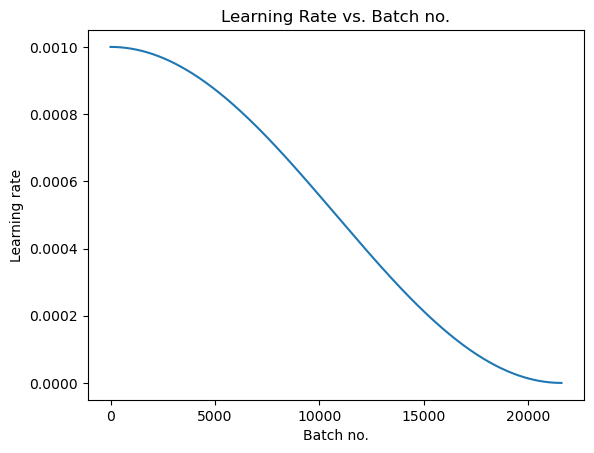

In [18]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

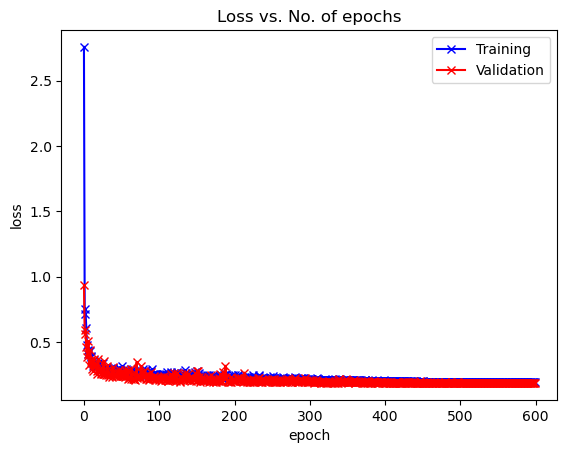

In [19]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['valid_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

plot_losses(history)

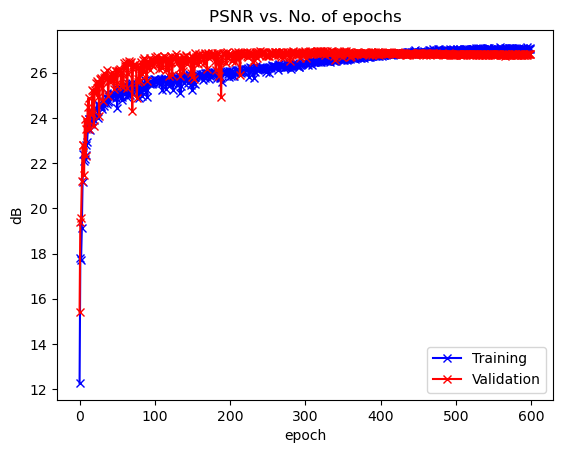

In [20]:
def plot_psnr(history):
  train_psnr = [x.get('train_psnr') for x in history]
  valid_psnr = [x.get('valid_psnr') for x in history]
  plt.plot(train_psnr, '-bx')
  plt.plot(valid_psnr, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('dB')
  plt.legend(['Training', 'Validation'])
  plt.title('PSNR vs. No. of epochs')

def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['valid_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

plot_psnr(history)